In [1]:
!pip install pandas pyarrow yfinance fortitudo_tech matplotlib numpy

  Using cached pandas-2.3.3-cp312-cp312-manylinux_2_24_x86_64.manylinux_2_28_x86_64.whl.metadata (91 kB)
  Using cached pyarrow-22.0.0-cp312-cp312-manylinux_2_28_x86_64.whl.metadata (3.2 kB)
  Using cached yfinance-0.2.66-py2.py3-none-any.whl.metadata (6.0 kB)
  Using cached fortitudo_tech-1.1.12-py3-none-any.whl.metadata (5.8 kB)
  Using cached matplotlib-3.10.7-cp312-cp312-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (11 kB)
  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2025.2-py2.py3-none-any.whl.metadata (1.4 kB)
  Using cached multitasking-0.0.12-py3-none-any.whl
  Using cached frozendict-2.4.7-py3-none-any.whl.metadata (23 kB)
  Using cached peewee-3.18.3-py3-none-any.whl
  Using cached curl_cffi-0.13.0-cp39-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (13 kB)
  Using cached protobuf-6.33.1-cp39-abi3-manylinux2014_x86_64.whl.metadata (593 bytes)
  Using cached websockets-15.0.1-cp312-cp312-manylinux_2_5_x86_64.ma

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import fortitudo.tech as ft
from cvxopt import matrix, solvers
from copy import copy
from time import time

In [12]:
# Load your data (replaces the yfinance download)
data = pd.read_parquet("merged_portfolio_data.parquet")
data['date'] = pd.to_datetime(data['date'])
data = data.set_index('date')
data = data[data > 0]
data_clean = data.dropna(axis=1, how='any').copy()

# Download VIX to add to your data
vix_raw = yf.download('^VIX', start=data_clean.index.min(), end=data_clean.index.max(), progress=False)
vix_series = vix_raw[('Close', '^VIX')] if ('Close', '^VIX') in vix_raw.columns else vix_raw['Close']
vix_series.name = '^VIX'

# Combine your assets with VIX (like the original has assets + VIX)
data = data_clean.join(vix_series, how='inner')

print(f'The number of daily observations is {len(data)}.')

The number of daily observations is 2470.


/tmp/ipykernel_501/2558915264.py:9: FutureWarning: YF.download() has changed argument auto_adjust default to True
  vix_raw = yf.download('^VIX', start=data_clean.index.min(), end=data_clean.index.max(), progress=False)


In [13]:
print(f'{np.round(len(data) / 252, 2)} years of daily data.')

9.8 years of daily data.


In [14]:
log_returns = np.diff(np.log(data.values[:, :-1]), axis=0)  # exclude the VIX

In [15]:
# Show daily historical return stats
stats = ft.simulation_moments(100 * log_returns)
stats.index = data.columns[:-1]
stats

,Mean,Volatility,Skewness,Kurtosis
A,0.054991,1.760946,-0.267989,9.493387
AAL,-0.043635,3.277374,0.514991,16.706909
AAP,-0.042014,2.747187,-0.544552,63.094458
AAPL,0.098369,1.841415,-0.098387,9.579890
ABBV,0.070917,1.656265,-1.153770,17.605488
...,...,...,...,...
AUD=X,0.004614,0.641432,0.264403,6.283609
CHF=X,-0.008660,0.473356,-0.515362,6.857597
^GSPC,0.049503,1.151361,-0.684464,19.444625
^NDX,0.070452,1.430680,-0.387177,11.084729


In [16]:
# VIX only state variable
vix = data.values[1:, -1]  # exclude first VIX observation to match returns
imp_vol_25pct = np.percentile(vix, 25)
low_vol_indices = vix <= imp_vol_25pct
imp_vol_90pct = np.percentile(vix, 90)
mid_vol_indices = (vix < imp_vol_25pct) ^ (vix <= imp_vol_90pct)
high_vol_indices = vix > imp_vol_90pct

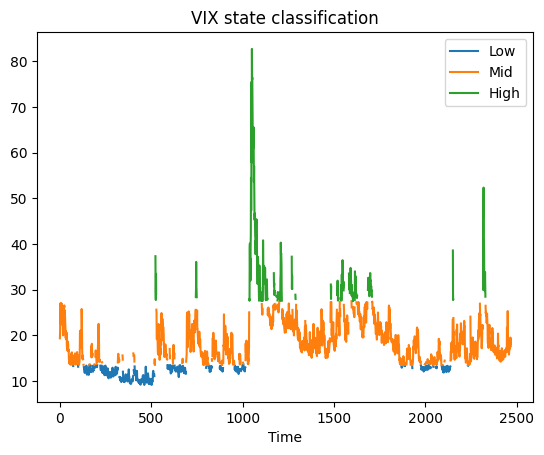

In [17]:
# Plot the 1m implied vol with state classification
vol_low = np.ma.masked_where(low_vol_indices == False, vix)
vol_mid = np.ma.masked_where(mid_vol_indices == False, vix)
vol_high = np.ma.masked_where(high_vol_indices == False, vix)
x = np.arange(0, len(vix))
plt.plot(x, vol_low, x, vol_mid, x, vol_high)
plt.xlabel('Time')
plt.legend(['Low', 'Mid', 'High'])
plt.title('VIX state classification')
plt.show()

In [18]:
# Exponential decay prior
T_tilde = len(log_returns)
p_exp = ft.exp_decay_probs(log_returns, half_life=T_tilde / 2)

# Compute view values for Entropy Pooling views
mu_low = np.mean(vix[low_vol_indices])
sigma_low = np.std(vix[low_vol_indices])
mu_mid = np.mean(vix[mid_vol_indices])
sigma_mid = np.std(vix[mid_vol_indices])
mu_high = np.mean(vix[high_vol_indices])
sigma_high = np.std(vix[high_vol_indices])

# Specify left hand sides for Entropy Pooling views
A = np.vstack((np.ones((1, T_tilde)), vix[np.newaxis, :]))  # probabilities sum to 1 and mean
b_low = np.array(([[1.], [mu_low]]))
b_mid = np.array(([[1.], [mu_mid]]))
b_high = np.array(([[1.], [mu_high]]))
G = vix[:, np.newaxis].T ** 2
h_low = np.array([[sigma_low ** 2 + mu_low ** 2]])
h_mid = np.array([[sigma_mid ** 2 + mu_mid ** 2]])
h_high = np.array([[sigma_high ** 2 + mu_high ** 2]])

# Compute Fully Flexible Resampling probability vectors
q_low = ft.entropy_pooling(p_exp, A, b_low, G, h_low)
q_mid = ft.entropy_pooling(p_exp, A, b_mid, G, h_mid)
q_high = ft.entropy_pooling(p_exp, A, b_high, G, h_high)

# Define a Fully Flexible Resampling function
def resampling(S, H, initial_state, states_prob, states_vector):
    sim = np.full((S, H), 1)
    t = np.arange(len(states_vector))
    for s in range(S):
        current_state = initial_state
        for h in range(H):
            sim[s, h] = np.random.choice(t, p=states_prob[:, current_state])
            current_state = states_vector[sim[s, h]]
    return sim

# Create state probabilities and vectors
states_prob = np.hstack((q_low / np.sum(q_low), q_mid / np.sum(q_mid), q_high / np.sum(q_high)))
states_vector = 0 * low_vol_indices + 1 * mid_vol_indices + 2 * high_vol_indices

# Simulate historical observations
S = 10000
H = 21
I = log_returns.shape[-1]
np.random.seed(1)

# Simulate with latest state
sim_indices = resampling(S, H, states_vector[-1], states_prob, states_vector)
return_sim_1m = np.exp(np.cumsum(log_returns[sim_indices], axis=1))[:, -1, :] - 1

In [26]:
# Print simulation stats
stats_sim = ft.simulation_moments(100 * return_sim_1m)
stats_sim.index = data.columns[:-1]
stats_sim

,Mean,Volatility,Skewness,Kurtosis
A,2.039453,7.805666,-0.006914,3.429843
AAL,1.874981,13.402251,0.445602,4.993538
AAP,0.466638,14.526889,1.732377,14.952058
AAPL,3.248485,7.959030,0.037067,3.820097
ABBV,2.461270,7.237292,0.048798,3.683301
...,...,...,...,...
AUD=X,-0.065158,2.823891,0.364455,4.237644
CHF=X,-0.254184,2.171403,-0.097447,3.601452
^GSPC,1.964911,4.548353,-0.656980,5.630789
^NDX,2.649745,5.949798,-0.300406,4.081045


In [27]:
# Note: In the original, they use I_stocks for the synthetic stocks
# For your data, we just use I (number of assets from log_returns)
I_stocks = I  # Keep the same naming convention as original

G = -np.eye(I_stocks)
h = np.zeros(I_stocks)
cvar_opt = ft.MeanCVaR(return_sim_1m, G, h)

In [28]:
return_target = np.mean(np.mean(return_sim_1m, axis=0))
start_time = time()
e_opt_prior = cvar_opt.efficient_portfolio(return_target)
print(f'Prior CVaR efficient portfolio for S={S} scenarios and I={I_stocks} '
      + f'stocks computed in {np.round(time() - start_time, 2)} seconds.')

Prior CVaR efficient portfolio for S=10000 scenarios and I=575 stocks computed in 236.49 seconds.


In [29]:
# Verify prior results
tol = 1e-10  # tolerance for numerical deviations from bounds
assert np.abs(np.sum(e_opt_prior) - 1) <= tol  # sum to 1
assert np.all(e_opt_prior >= 0 - tol)  # long-only
assert np.abs(np.mean(return_sim_1m @ e_opt_prior) - return_target) <= tol  # return target

In [30]:
# Entropy Pooling S&P 500 view (^GSPC is at position -3, since -1 is VIX)
A_ep = np.vstack((np.ones((1, S)), return_sim_1m[:, -3][np.newaxis, :]))
b_ep = np.array([[1], [np.mean(return_sim_1m[:, -3]) * 1.1]])  # 10% relative increase in the S&P 500 expected return
q = ft.entropy_pooling(np.ones((S, 1)) / S, A_ep, b_ep)

In [31]:
# Posterior CVaR optimization
cvar_opt_post = ft.MeanCVaR(return_sim_1m, G, h, p=q)
return_target_post = np.mean(q.T @ return_sim_1m)
start_time = time()
e_opt_post = cvar_opt_post.efficient_portfolio(return_target_post)
print(f'Posterior CVaR efficient portfolio for S={S} scenarios and I={I_stocks} '
      + f'stocks computed in {np.round(time() - start_time, 2)} seconds.')

Posterior CVaR efficient portfolio for S=10000 scenarios and I=575 stocks computed in 234.5 seconds.


In [32]:
# Verify posterior results
assert np.abs(np.sum(e_opt_post) - 1) <= tol  # sum to 1
assert np.all(e_opt_post >= 0 - tol)  # long-only
assert np.abs(q.T @ return_sim_1m @ e_opt_post - return_target_post) <= tol  # return target

In [35]:
# Create DataFrame with optimal weights in PERCENTAGE
import pandas as pd

optimal_weights = pd.DataFrame({
    'Prior': e_opt_prior.flatten() * 100,  # Convert to %
    'Posterior': e_opt_post.flatten() * 100,  # Convert to %
    'Difference': (e_opt_post - e_opt_prior).flatten() * 100  # Convert to %
}, index=data.columns[:-1])  # Exclude VIX from column names

# Filter to only show positions > 0.1%
optimal_weights_filtered = optimal_weights[(optimal_weights['Prior'] > 0.1) | 
                                            (optimal_weights['Posterior'] > 0.1)]

# Sort by Prior weight
optimal_weights_filtered = optimal_weights_filtered.sort_values('Prior', ascending=False)

print("\n" + "="*70)
print("OPTIMAL PORTFOLIO WEIGHTS (%)")
print("="*70)
print(optimal_weights_filtered)

print("\n" + "="*70)
print("TOP 10 PRIOR HOLDINGS (%)")
print("="*70)
top_prior = optimal_weights.nlargest(10, 'Prior')[['Prior', 'Posterior']]
print(top_prior)

print("\n" + "="*70)
print("TOP 10 POSTERIOR HOLDINGS (%)")
print("="*70)
top_post = optimal_weights.nlargest(10, 'Posterior')[['Prior', 'Posterior']]
print(top_post)

print("\n" + "="*70)
print("BIGGEST ALLOCATION INCREASES (Posterior - Prior) (%)")
print("="*70)
biggest_increases = optimal_weights.nlargest(10, 'Difference')[['Prior', 'Posterior', 'Difference']]
print(biggest_increases)

print("\n" + "="*70)
print("BIGGEST ALLOCATION DECREASES (Posterior - Prior) (%)")
print("="*70)
biggest_decreases = optimal_weights.nsmallest(10, 'Difference')[['Prior', 'Posterior', 'Difference']]
print(biggest_decreases)

print("\n" + "="*70)
print("PORTFOLIO SUMMARY")
print("="*70)
print(f"Prior Portfolio:")
print(f"  Number of positions: {(e_opt_prior.flatten() > 0.001).sum()}")
print(f"  Max weight: {e_opt_prior.max()*100:.2f}%")
print(f"  Top 10 concentration: {np.sort(e_opt_prior.flatten())[-10:].sum()*100:.2f}%")
print(f"\nPosterior Portfolio:")
print(f"  Number of positions: {(e_opt_post.flatten() > 0.001).sum()}")
print(f"  Max weight: {e_opt_post.max()*100:.2f}%")
print(f"  Top 10 concentration: {np.sort(e_opt_post.flatten())[-10:].sum()*100:.2f}%")


OPTIMAL PORTFOLIO WEIGHTS (%)
              Prior  Posterior  Difference
GBP=X  1.682140e+01  14.672447   -2.148950
GC=F   1.623563e+01  17.028317    0.792688
JPY=X  1.604871e+01  17.078465    1.029753
AUD=X  8.645673e+00   6.257896   -2.387777
EUR=X  6.764480e+00   7.591329    0.826849
EMC    5.178567e+00   6.926589    1.748022
K      3.215846e+00   2.815236   -0.400610
COR    2.919824e+00   3.418093    0.498269
WMT    2.787475e+00   4.237225    1.449750
CBOE   2.483771e+00   2.047284   -0.436487
GRN    1.827529e+00   1.620568   -0.206961
KG     1.785819e+00   1.638679   -0.147140
LDOS   1.718083e+00   0.821781   -0.896302
TKO    1.477786e+00   0.571180   -0.906606
HOLX   1.269752e+00   0.000000   -1.269752
NVDA   1.232753e+00   1.656473    0.423721
AZO    1.061380e+00   0.933741   -0.127639
GWW    9.644053e-01   0.000000   -0.964405
MKTX   9.300303e-01   0.396654   -0.533377
CA     9.046166e-01   0.848570   -0.056046
MO     8.747547e-01   1.702823    0.828068
UNH    8.481752e-01   0